# Working with whole-body dataset

In [1]:
#For working wit Nifti file images on python-ipynb we need some new libraries
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Volume import Volume

In [3]:
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress = True)

In [4]:
# Running from home PC file location in data (inside repo, not commited yet)
ct_wb_seg = nib.load("post_processing/final_total_seg.nii.gz")
# This variables are instances of the nibabel image
# To work with the data:
labels = ct_wb_seg.get_fdata()
labels.shape


(400, 400, 326)

In [5]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Center slices for CT-WB segmentated')

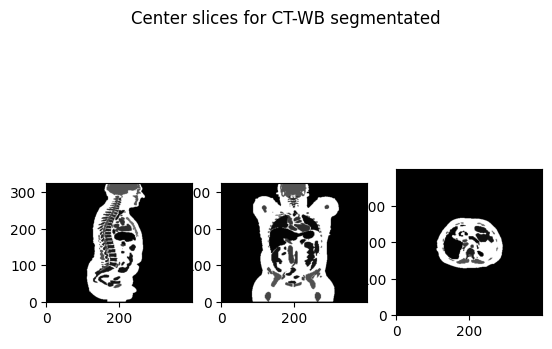

In [6]:
slice_0 = labels[200, :, :]
slice_1 = labels[:, 200, :]
slice_2 = labels[:, :, 163]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for CT-WB segmentated") 
#COlor for the image

In [7]:
# New code for better experimental branch
new_vol = Volume(ct_wb_seg)


In [8]:
new_vol.create_segmentation_labels()
sus_dist = new_vol.create_sus_dist()


Label ID 256 not found.
Label ID 256 not found.
Label ID 289 not found.
Label ID 289 not found.


In [7]:
#pd_dist = new_vol.create_pd_vol()

In [11]:
#new_vol.save_sus_dist_nii()

In [12]:
#new_vol.save_pd_dist()

In [9]:
new_vol.calculate_deltaB0()

In [ ]:
new_vol.save_deltaB0()

In [10]:
TE_list = [0.008, 0.0095, 0.011, 0.0125, 0.014, 0.0155]
flip_ang = 24

new_vol.simulate_measurement(flip_ang,TE_list)


AttributeError: 'Volume' object has no attribute 'magnitude'